In [26]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras import Sequential, layers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.losses import sparse_categorical_crossentropy

In [2]:
df = pd.read_csv('../data/data_clean.csv')

In [3]:
from scripts.data_cleaner import filter_top_cpv_categories

df = filter_top_cpv_categories(df, top_n=150, cpv_column='codeCPV_3')

Filtered from 392 to 150 CPV categories, keeping 279174 rows out of 286850


In [4]:
df.drop(df[df['montant'] > 999999].index, inplace=True)
df.shape

(238163, 38)

In [5]:
y = np.log1p(df['montant'])
y.head()

0    11.292279
1    10.882925
4    13.235694
5    11.350889
6    12.044412
Name: montant, dtype: float64

In [6]:
bins = np.linspace(y.min(), y.max(), 10)

# Créer les étiquettes correspondantes
labels = list(range(1, len(bins)))

# Ajouter la colonne fourchette_de_prix
df['bins'] = pd.cut(y, bins=bins, labels=labels, include_lowest=True, right=True)

df.shape

(238163, 39)

In [7]:
np.exp(bins)

array([  20001.        ,   30890.41494143,   47708.50133762,
         73683.08597334,  113799.36502582,  175756.69245133,
        271446.28561345,  419233.45817256,  647482.39989405,
       1000000.        ])

In [8]:
df['bins'].isna().sum()

0

In [9]:
df['bins'] = df['bins'].astype('int')

In [10]:
df['bins'].unique

<bound method Series.unique of 0         4
1         3
4         8
5         4
6         5
         ..
286844    3
286845    5
286846    2
286848    9
286849    2
Name: bins, Length: 238163, dtype: int64>

In [11]:
df = df.drop(columns='montant')
df.columns

Index(['uid', 'id', 'nature', 'acheteur_id', 'acheteur_nom', 'acheteur_siren',
       'titulaire_id', 'titulaire_typeIdentifiant', 'titulaire_nom',
       'titulaire_siren', 'objet', 'codeCPV', 'procedure', 'dureeMois',
       'dateNotification', 'datePublicationDonnees', 'formePrix',
       'attributionAvance', 'offresRecues', 'marcheInnovant', 'ccag',
       'sousTraitanceDeclaree', 'typeGroupementOperateurs', 'tauxAvance',
       'origineUE', 'origineFrance', 'lieuExecution_code',
       'lieuExecution_typeCode', 'idAccordCadre', 'source_open_data',
       'codeCPV_FR', 'codeCPV_2', 'codeCPV_3', 'codeCPV_4', 'codeCPV_5',
       'codeCPV_2_3', 'annee', 'bins'],
      dtype='object')

In [12]:
X = df.drop(columns='bins')
y = df['bins']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=X['codeCPV_3'])

In [14]:
from scripts.preprocess_pipeline import create_pipeline_cat

cat_list = ['marche_sim', 'pred_montant', 'anomalie']
cat = cat_list[1]
pipeline = create_pipeline_cat(cat)

In [15]:
X_train_preproc = pipeline.fit_transform(X_train)

In [16]:
X_train_preproc.shape

(190530, 184)

In [17]:
from keras.utils import to_categorical
y_train_cat = to_categorical(y_train)

In [23]:
y_train_cat.shape

(190530, 10)

In [18]:
#Création du model --> couches Dense

In [29]:
# Modèle
model = Sequential()

# Entrée
model.add(layers.Input(shape=(184,)))

# Couches cachées
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

# Couche de sortie : 10 classes
model.add(layers.Dense(10, activation='softmax'))

# Compilation du modèle
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # ou 'sparse_categorical_crossentropy' si tes labels sont des entiers
    metrics=['accuracy',]
)

# Affichage du résumé
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 512)            │        94,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 263,818 (1.01 MB)

 Trainable params: 262,026 (1023.54 KB)

 Non-trainable params: 1,792 (7.00 KB)

In [20]:
# model.compile(
#     optimizer='adam',
#     loss='categorical_crossentropy',
#     metrics=['accuracy', 'precision', 'recall'])

In [30]:
es = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
        X_train_preproc, y_train_cat,
        validation_split=0.2,
        batch_size=32,
        epochs=100,
        callbacks=[es],
        verbose=1)

Epoch 1/100
4764/4764 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.1802 - loss: 2.2066 - val_accuracy: 0.2010 - val_loss: 1.9741
Epoch 2/100
4764/4764 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.2043 - loss: 1.9819 - val_accuracy: 0.2133 - val_loss: 1.9569
Epoch 3/100
4764/4764 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.2119 - loss: 1.9665 - val_accuracy: 0.2211 - val_loss: 1.9463
Epoch 4/100
4764/4764 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.2167 - loss: 1.9548 - val_accuracy: 0.2197 - val_loss: 1.9427
Epoch 5/100
4764/4764 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.2192 - loss: 1.9462 - val_accuracy: 0.2226 - val_loss: 1.9357
Epoch 6/100
4764/4764 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.2248 - loss: 1.9358 - val_accuracy: 0.2253 - val_loss: 1.9364
Epoch 7/100
4764/4764 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.2266 - loss: 1.9289 - val_accuracy: 0.2290 - val_loss: 1.9291
Epoch 8/100
4764/4764 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.2331 - loss:

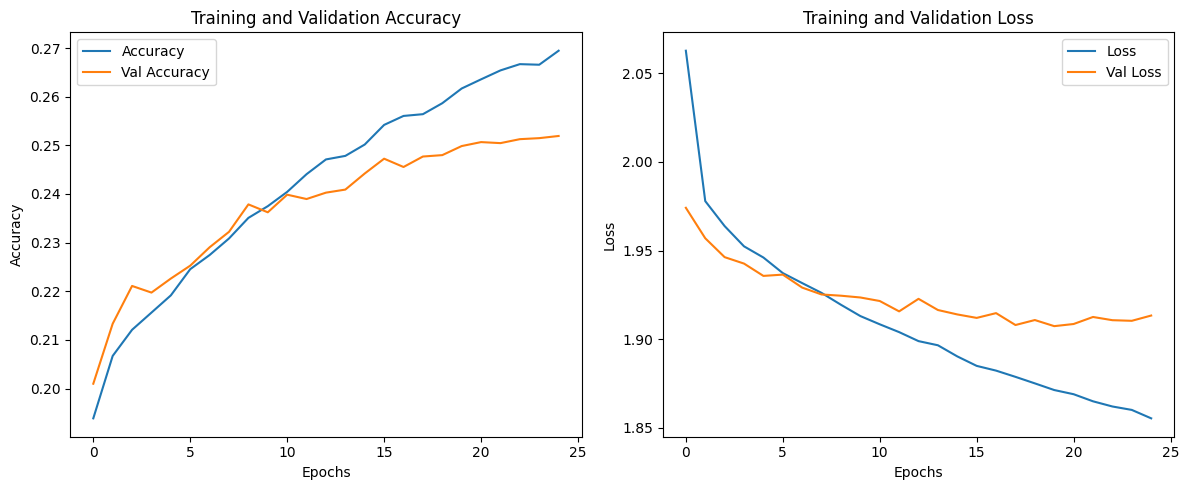

In [31]:
# Récupération des données d'entraînement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Création de la figure
plt.figure(figsize=(12, 5))

# Plot de l'accuracy
plt.subplot(1, 2, 1)
plt.plot(acc, label='Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot de la loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Loss')
plt.plot(val_loss, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Affichage
plt.tight_layout()
plt.show()

In [32]:
X_test_preproc = pipeline.transform(X_test)

/Users/paulcolas/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [33]:
y_test_cat = to_categorical(y_test)

In [34]:
print(X_test_preproc.shape)
print(y_test_cat.shape)

(47633, 184)
(47633, 10)


In [35]:
y_new = model.predict(X_test_preproc)

1489/1489 ━━━━━━━━━━━━━━━━━━━━ 1s 502us/step


In [ ]:
one_hot = np.zeros_like(y_new)
one_hot[np.arange(len(y_new)), y_new.argmax(axis=1)] = 1


array([0., 1.], dtype=float32)

In [44]:
y_test_cat = to_categorical(y_test)
model.evaluate(X_test_preproc, y_test_cat)

1489/1489 ━━━━━━━━━━━━━━━━━━━━ 1s 599us/step - accuracy: 0.2485 - loss: 1.9016


[1.9010255336761475, 0.24749648571014404]

In [45]:
y_test_cat.shape

(47633, 10)

In [47]:
from sklearn.metrics import classification_report

print(classification_report(y_test_cat, one_hot))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.19      0.05      0.07      1219
           2       0.26      0.08      0.12      4335
           3       0.26      0.50      0.34      7815
           4       0.22      0.29      0.25      8080
           5       0.21      0.19      0.20      7051
           6       0.25      0.16      0.20      6810
           7       0.24      0.25      0.24      5117
           8       0.32      0.22      0.26      4172
           9       0.41      0.15      0.22      3034

   micro avg       0.25      0.25      0.25     47633
   macro avg       0.24      0.19      0.19     47633
weighted avg       0.25      0.25      0.23     47633
 samples avg       0.25      0.25      0.25     47633



/Users/paulcolas/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/paulcolas/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/paulcolas/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control 